In [2]:
# Importing Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score, roc_curve
# Import dataset
data = pd.read_csv('ML_final_eval.csv')

In [3]:
# replacing unknown for binary columns
data['default'] = data['default'].replace('unknown','no')
for i in ['housing','loan']:
    data[i]= data[i].replace('unknown', data[i].mode()[0])
# Cliping outliers 
for col in ['age', 'cons.conf.idx']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[col] = data[col].clip(lower, upper)

# Label Encoding Binary Columns
le = LabelEncoder()
for i in ['default','housing','loan','y']:
    data[i] = le.fit_transform(data[i])
# Encoding month and day_of_week features
day_map = {'mon':1,'tue':2,'wed':3,'thu':4,'fri':5,'sat':6,'sun':7}
month_map = {'jan':1, 'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
data['dow_num'] = data['day_of_week'].map(day_map)
data['month_num'] = data['month'].map(month_map)
# New features
data['contacted_before'] = (data['previous'] > 0).astype(int)
data['campaign_intensity'] = data['campaign'] / data['previous'].replace(0, 1)
data['job_education'] = data['job'] + '_' + data['education']
data['job_education'] = data['job_education'].where(data['job_education'].map(data['job_education'].value_counts()) > 800,'Other')
# Encoding Categorical features
cat_cols = ['job','job_education','education','marital','contact','poutcome']
data_en = pd.get_dummies(data, columns=cat_cols, drop_first=True)
# dropping unnecessary columns 
data_en.drop(columns=['duration','previous','pdays','no.employed','month','day_of_week'], inplace=True)
data_en.corr()['y'].sort_values(ascending=False).head(10)

y                                         1.000000
poutcome_success                          0.316269
contacted_before                          0.193507
job_student                               0.093955
job_retired                               0.092221
cons.conf.idx                             0.054789
marital_single                            0.054133
education_university.degree               0.050364
job_education_admin._university.degree    0.038744
month_num                                 0.037187
Name: y, dtype: float64

In [4]:
# Spliting the data
x = data_en.drop(columns='y')
y = data_en['y']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=42)
# Scalling the numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
# logistic Regression
lr = LogisticRegression(class_weight='balanced',max_iter=1000)
lr.fit(X_train_sc, y_train)
y_pred_lr = lr.predict(X_test_sc)
y_prob_lr = lr.predict_proba(X_test_sc)[:,1]
# Random Forest
rf = RandomForestClassifier(n_estimators=200,max_depth=10,random_state=42,class_weight='balanced')
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]
# Gradient Boosing
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
y_prob_gb = gb.predict_proba(X_test)[:,1]

In [5]:
print("LOGISTIC REGRESSION:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("RANDOM FOREST")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))
print("GRADIENT BOOSTING")
print(confusion_matrix(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

LOGISTIC REGRESSION:
[[5923 1387]
 [ 297  631]]
              precision    recall  f1-score   support

           0       0.95      0.81      0.88      7310
           1       0.31      0.68      0.43       928

    accuracy                           0.80      8238
   macro avg       0.63      0.75      0.65      8238
weighted avg       0.88      0.80      0.83      8238

RANDOM FOREST
[[6446  864]
 [ 326  602]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      7310
           1       0.41      0.65      0.50       928

    accuracy                           0.86      8238
   macro avg       0.68      0.77      0.71      8238
weighted avg       0.89      0.86      0.87      8238

GRADIENT BOOSTING
[[7211   99]
 [ 718  210]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.68      0.23      0.34       928

    accuracy                           0.90     

In [6]:
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Gradient Boosting'],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_gb)
    ]
})

results

,Model,ROC-AUC
0,Logistic Regression,0.792273
1,Random Forest,0.809096
2,Gradient Boosting,0.809342


In [7]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(
    rf, X_train, y_train, cv=5, scoring='roc_auc')

print("Mean CV ROC-AUC:", cv_scores.mean())


Mean CV ROC-AUC: 0.794335716937125


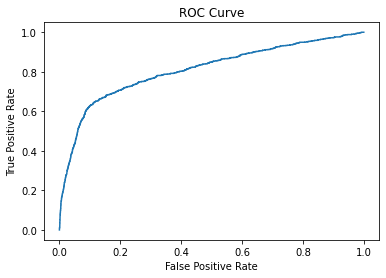

In [8]:
param_grid = {'n_estimators': [100, 200],'max_depth': [8, 10]}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),param_grid,scoring='roc_auc',cv=5)
grid.fit(X_train, y_train)
grid.fit(X_train, y_train)


fpr, tpr, _ = roc_curve(y_test, y_prob_rf)
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [9]:
feature_imp = pd.Series(
    rf.feature_importances_,
    index=x.columns
).sort_values(ascending=False)

feature_imp.head(15)

euribor3m               0.223230
emp.var.rate            0.182174
cons.conf.idx           0.105280
cons.price.idx          0.076697
poutcome_success        0.071188
month_num               0.053366
age                     0.044313
contacted_before        0.029815
contact_telephone       0.028798
campaign_intensity      0.026553
poutcome_nonexistent    0.024850
campaign                0.018481
dow_num                 0.015555
job_blue-collar         0.008439
job_retired             0.007009
dtype: float64